CelebA Without Attribute Annotation
===

---

### *Notebook Overview*:
This notebook evaluates the robustness of the Diverse Prototypical Ensemble (DPE) method on the CelebA dataset in the absence of attribute annotations. Unlike the Waterbirds setting where group labels are used to construct balanced subsets, this experiment simulates a more realistic scenario in which only class labels are available. Despite this, DPE remains effective by using class-balanced subsampling from the validation set. We compare DPE against ERM and a strong baseline, DFR (Deep Feature Reweighting), across various metrics and prototype ensemble sizes.


In [1]:
from pandas.tests.series.methods.test_rank import results
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

from utils.misc import fix_random_seed

fix_random_seed(0)

### 1. Dataset Visualization

The CelebA dataset is loaded with standard splits. The target task is binary classification: **blond vs. non-blond** hair. Spurious correlations exist between gender and hair color, forming four implicit subgroups:
- Blond Female
- Blond Male
- Non-blond Female
- Non-blond Male

Since attribute labels are not used during training, this experiment relies solely on class labels for data sampling. The visualizations illustrate subgroup composition in the validation and test sets and provide insight into the imbalance of subgroups in the original training distribution.


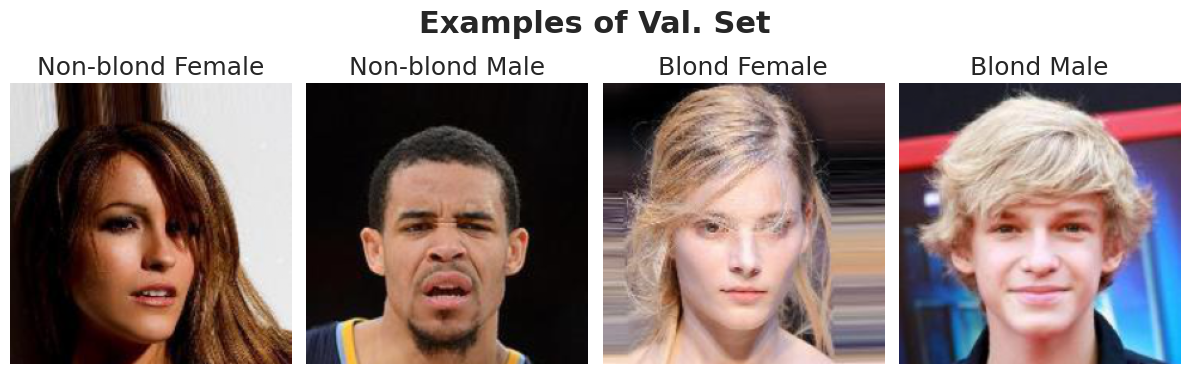

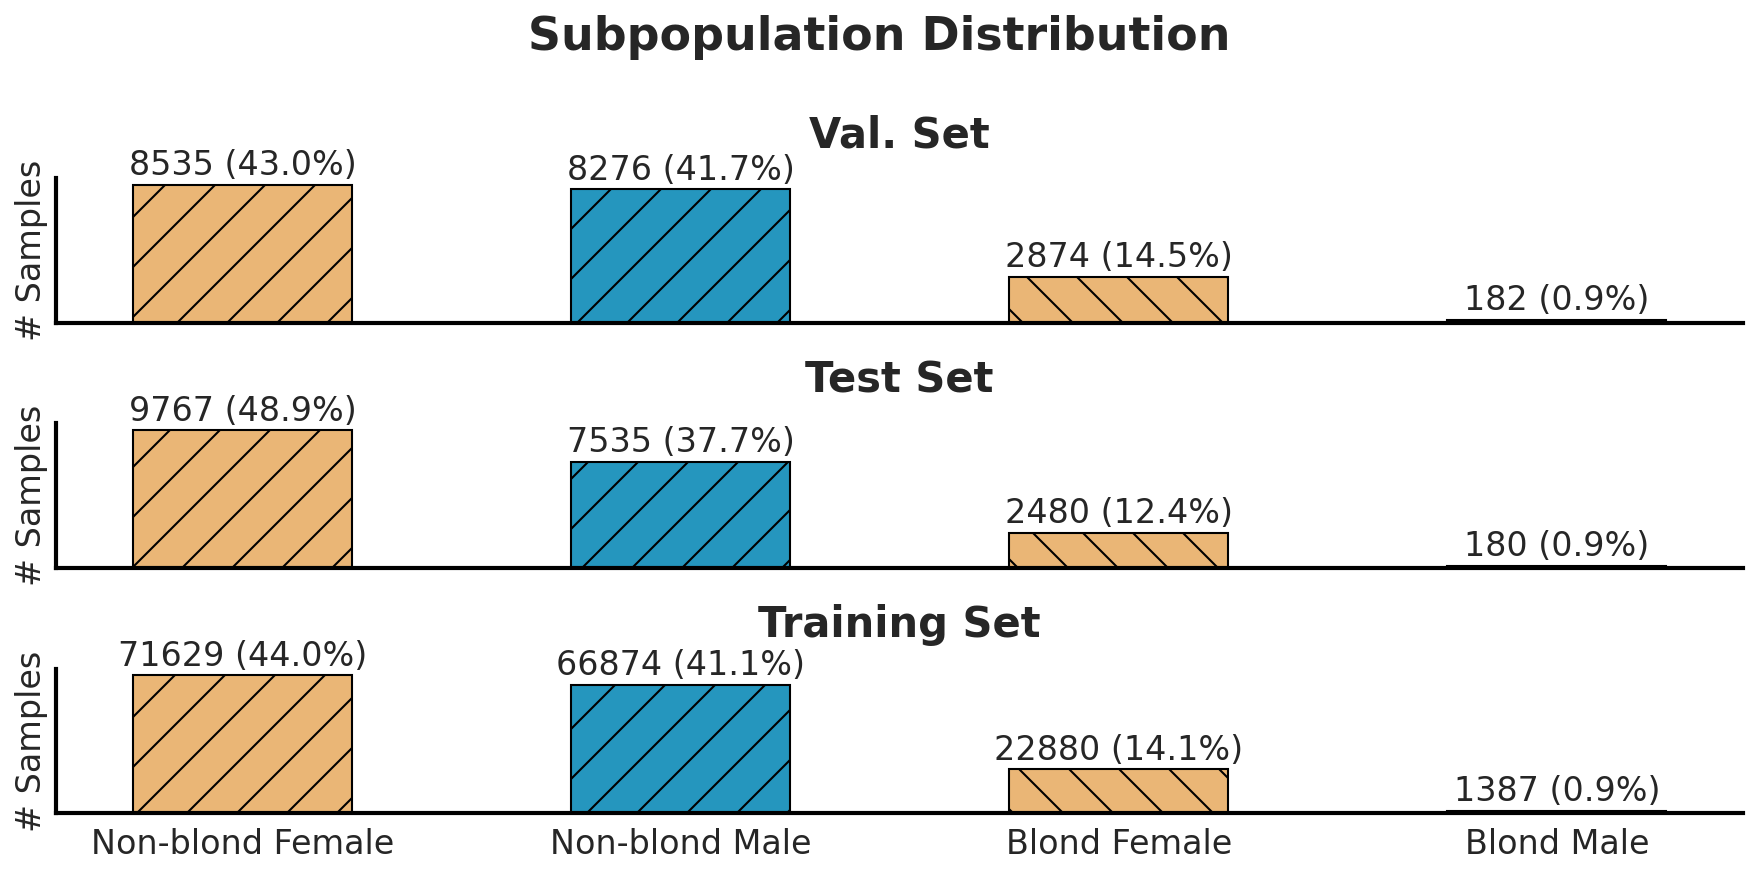

In [2]:
import numpy as np
from torch.utils.data import DataLoader

from utils import datasets as dsets
from notebooks.src.utils_plot import show_examples, plot_distributions

dataset_name = 'CelebA'
data_dir = '/scratch/ssd004/scratch/minht/datasets/'

datasets, dataloaders = dict(), dict()
datasets['val'] = vars(dsets)[dataset_name](data_dir, 'va', None)
datasets['test'] = vars(dsets)[dataset_name](data_dir, 'te', None)
datasets['train_eval'] = vars(dsets)[dataset_name](data_dir, 'tr', None)

set_name = 'val'
groups_dict = {'00': 'Non-blond Female', '01': 'Non-blond Male', '10': 'Blond Female',
               '11': 'Blond Male'}
show_examples(datasets, groups_dict, set_name)
plot_distributions(datasets, groups_dict)

### 2. ERM Evaluation

We evaluate an ERM classifier trained with class labels on the full (biased) training set. Group labels are used only for evaluation purposes. The results show strong performance on majority subgroups but substantially lower accuracy on minority groups, highlighting the need for robust methods under subpopulation shift.


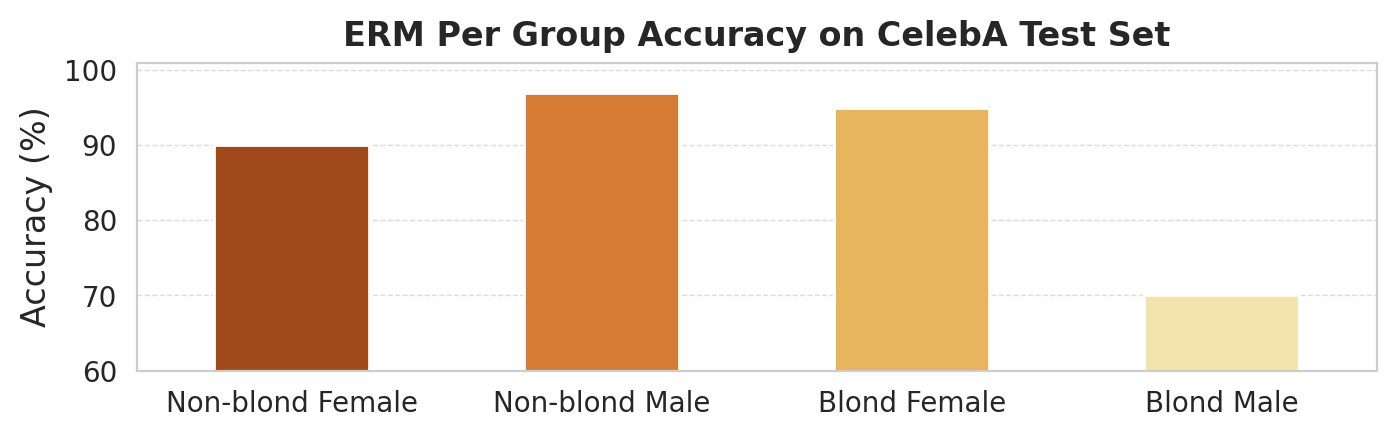

In [3]:
import seaborn as sns
from notebooks.src.utils_plot import show_erm_per_group_accuracy
from notebooks.src.utils import get_pre_extracted_features, init_erm_model, evaluate

workers = 10
num_classes = 2  # Blond vs Non-blond
ckpt_dir = '/scratch/ssd004/scratch/minht/checkpoints/sd0/CelebA/13571301/'


for set_name in ['val', 'test']:
    datasets[set_name].feats = get_pre_extracted_features(ckpt_dir, set_name)
    dataloaders[set_name] = DataLoader(dataset=datasets[set_name], num_workers=workers, pin_memory=False,
                                       batch_size=256, shuffle=False, drop_last=False)

erm_model = init_erm_model(ckpt_dir + 'ckpt_last.pt', num_classes=num_classes)
results = dict()
results['ERM'] = evaluate(erm_model, dataloaders['test'])
show_erm_per_group_accuracy(results['ERM'], groups_dict, dataset_name=dataset_name,
                            palette=sns.color_palette('YlOrBr', len(np.unique(datasets['test'].g)))[::-1])

### 3. Constructing a Balanced Subset (Without Attribute Labels)

To approximate a balanced representation, we subsample the validation set to ensure class balance. While this approach lacks explicit group supervision, it still enables the training of diverse classifier heads.


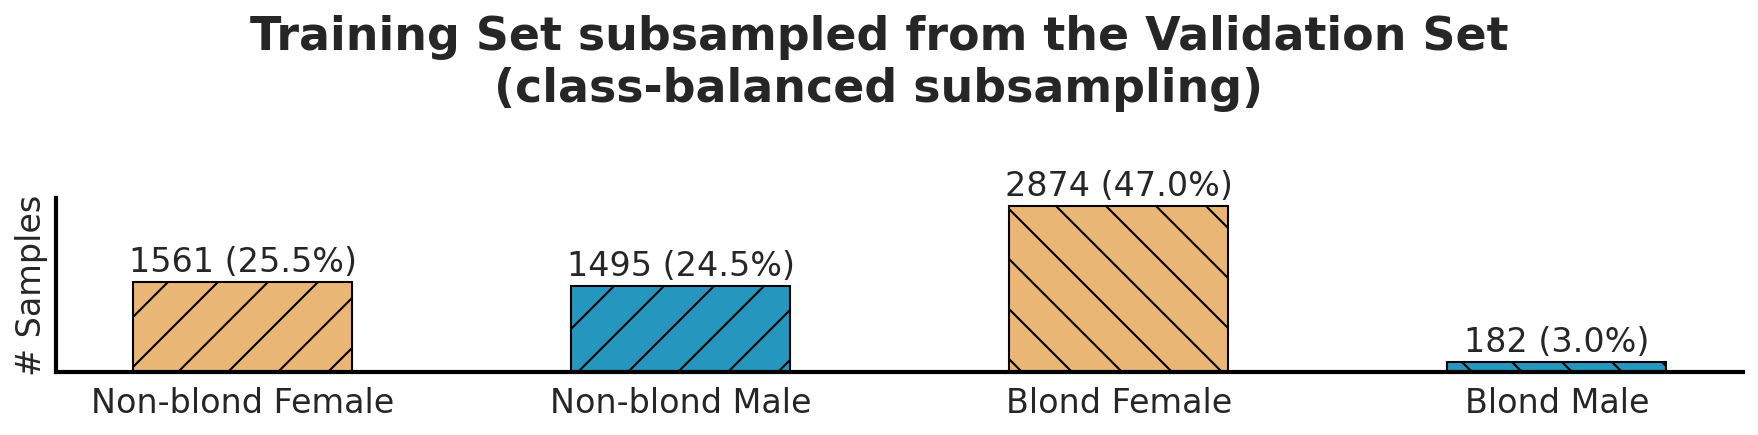

In [13]:
from notebooks.src.utils_plot import plot_distributions
from notebooks.src.utils import get_subsampled_train_set

plot_distributions(get_subsampled_train_set(attr_availability='no', dataset_name=dataset_name), groups_dict, fig_size=(12, 3),
                   title='Training Set subsampled from the Validation Set\n(class-balanced subsampling)',
                   set_name_dict={'train': ''})

### 4. DPE Training Without Attribute Annotation

We train a Diverse Prototypical Ensemble (DPE), where each ensemble member is a prototype-based classifier trained on a different randomly sampled class-balanced subset of the validation set. Despite the absence of group labels, we regularize the ensemble using an inter-prototype similarity loss to increase diversity across ensemble members. Each member has one prototype per class, and the final prediction is obtained by averaging logits across all members.


In [5]:
from functools import partial
from notebooks.src.utils import init_model, train_ensemble, get_train_loader

train_ensemble_func = partial(
    train_ensemble, datasets=datasets, dataloaders=dataloaders, lr=5e-4, seed=2, epochs=20, num_stages=15,
    init_train_loader=partial(get_train_loader, attr_availability='no', workers=8, dataset_name=dataset_name,
                              batch_size=256),
    init_model_func=partial(init_model, ckpt_path=ckpt_dir + 'ckpt_last.pt', device='cuda', num_classes=num_classes),
)
metrics = dict()
metrics['DPE'] = train_ensemble_func(cov_reg=5e5, random_subset=True)

[Stage 1] Epoch 20: 100%|██████████| 23/23 [00:00<00:00, 38.99it/s, loss=0.189, clf=0.149, cov=0, acc=94.48%, val wga=80.22%]


Avg ACC: 0.932
ACC per group: [0.913, 0.955, 0.947, 0.811]
Ensemble WGA: 81.1


[Stage 15] Epoch 20: 100%|██████████| 23/23 [00:00<00:00, 37.65it/s, loss=0.242, clf=0.187, cov=1.33e-8, acc=92.71%, val wga=50.55%]


Avg ACC: 0.922
ACC per group: [0.892, 0.948, 0.968, 0.839]
Ensemble WGA: 83.9


### 5. Training DFR as a Baseline

For comparison, we train [Deep Feature Reweighting (DFR)](https://github.com/PolinaKirichenko/deep_feature_reweighting), a state-of-the-art method for robust learning under subpopulation shift. Like DPE, DFR is trained on class-balanced subsets without subgroup supervision. However, DFR uses a linear classifier and does not include an explicit diversification strategy.


In [6]:
from functools import partial
from notebooks.src.utils import train_ensemble, get_train_loader

train_ensemble_func = partial(
    train_ensemble, datasets=datasets, dataloaders=dataloaders, lr=1e-3,
    seed=2, loss_name='ce', num_stages=15, epochs=20,
    init_train_loader=partial(get_train_loader, attr_availability='no', workers=8, dataset_name=dataset_name,
                              batch_size=256),
    init_model_func=partial(init_erm_model, ckpt_path=ckpt_dir + 'ckpt_last.pt', device='cuda', num_classes=num_classes)
)
metrics['DFR'] = train_ensemble_func(random_subset=True)

[Stage 1] Epoch 20: 100%|██████████| 23/23 [00:00<00:00, 40.94it/s, loss=0.383, clf=0.218, cov=0, acc=93.24%, val wga=66.48%]


Avg ACC: 0.905
ACC per group: [0.879, 0.929, 0.945, 0.733]
Ensemble WGA: 73.3


[Stage 15] Epoch 20: 100%|██████████| 23/23 [00:00<00:00, 38.11it/s, loss=0.392, clf=0.227, cov=0, acc=92.66%, val wga=65.38%]


Avg ACC: 0.934
ACC per group: [0.905, 0.967, 0.957, 0.75]
Ensemble WGA: 75.0


### 6. Performance Comparison: WGA and Balanced Accuracy

We compare DPE and DFR in terms of worst-group accuracy (WGA) and balanced accuracy. These metrics are plotted against the number of classifiers (or ensemble heads). The results show that DPE achieves higher WGA even with fewer ensemble members. Furthermore, DFR plateaus in performance as the ensemble grows, while DPE continues to improve with additional prototypes due to its diversified representation.


/fs01/home/minht/projects/diversified_prototypical_ensemble/notebooks/src/utils_plot.py:486: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  _ = sns.lineplot(
/fs01/home/minht/projects/diversified_prototypical_ensemble/notebooks/src/utils_plot.py:486: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  _ = sns.lineplot(


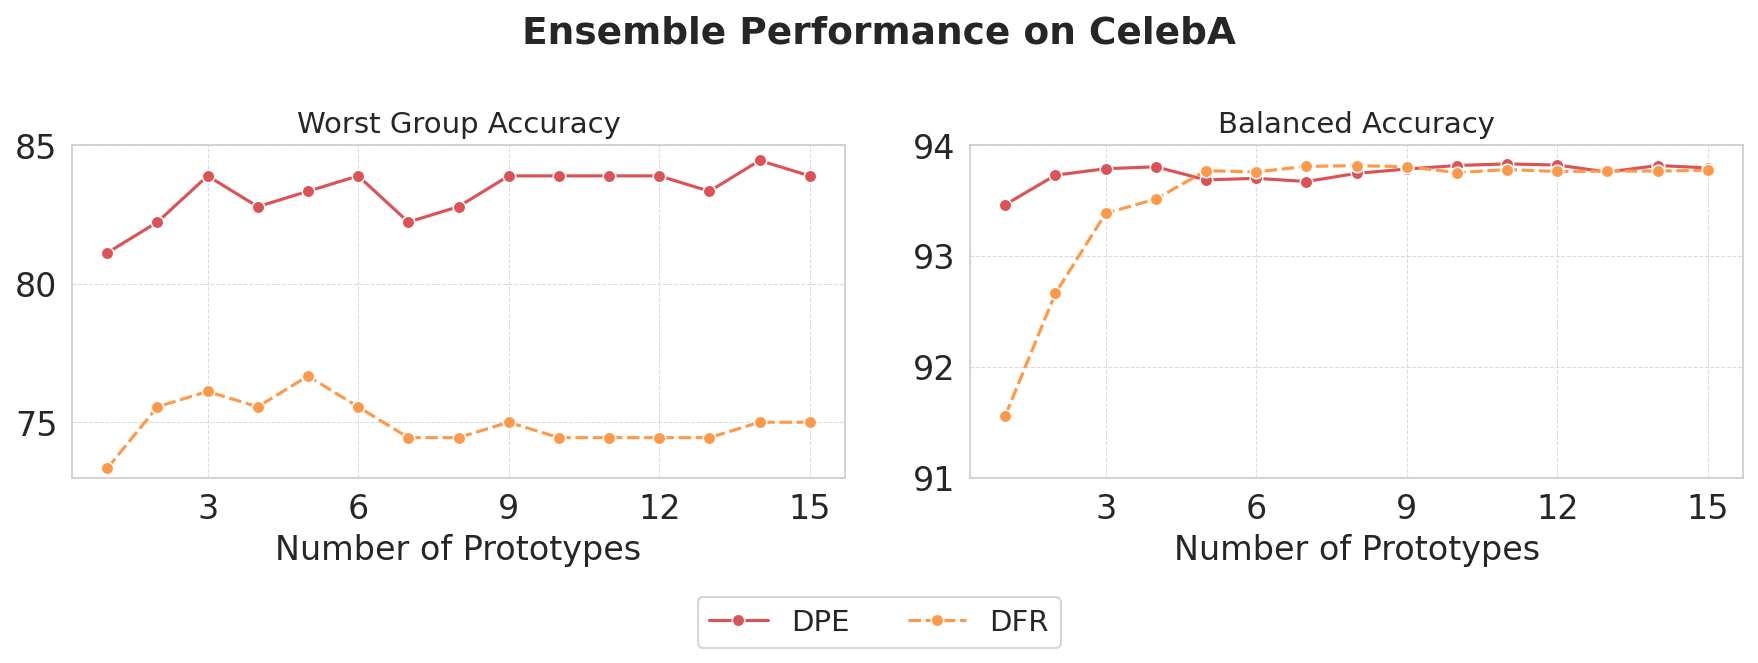

In [9]:
import pylab as plt
from notebooks.src.utils_plot import dict_to_df, plot_metrics

df = dict_to_df(metrics)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
plot_metrics(df, 'Worst Group Accuracy', axes[0], dataset_name=dataset_name)
plot_metrics(df, 'Balanced Accuracy', axes[1], show_legend=True, dataset_name=dataset_name)

### 7. Per-Group Accuracy Comparison

The final visualization compares per-group accuracy across ERM, DPE, and DFR. The results highlight two key observations:
- DPE improves performance on the most underrepresented subgroups without degrading accuracy on majority subgroups.
- DFR achieves moderate gains but fails to equalize subgroup performance as effectively as DPE.


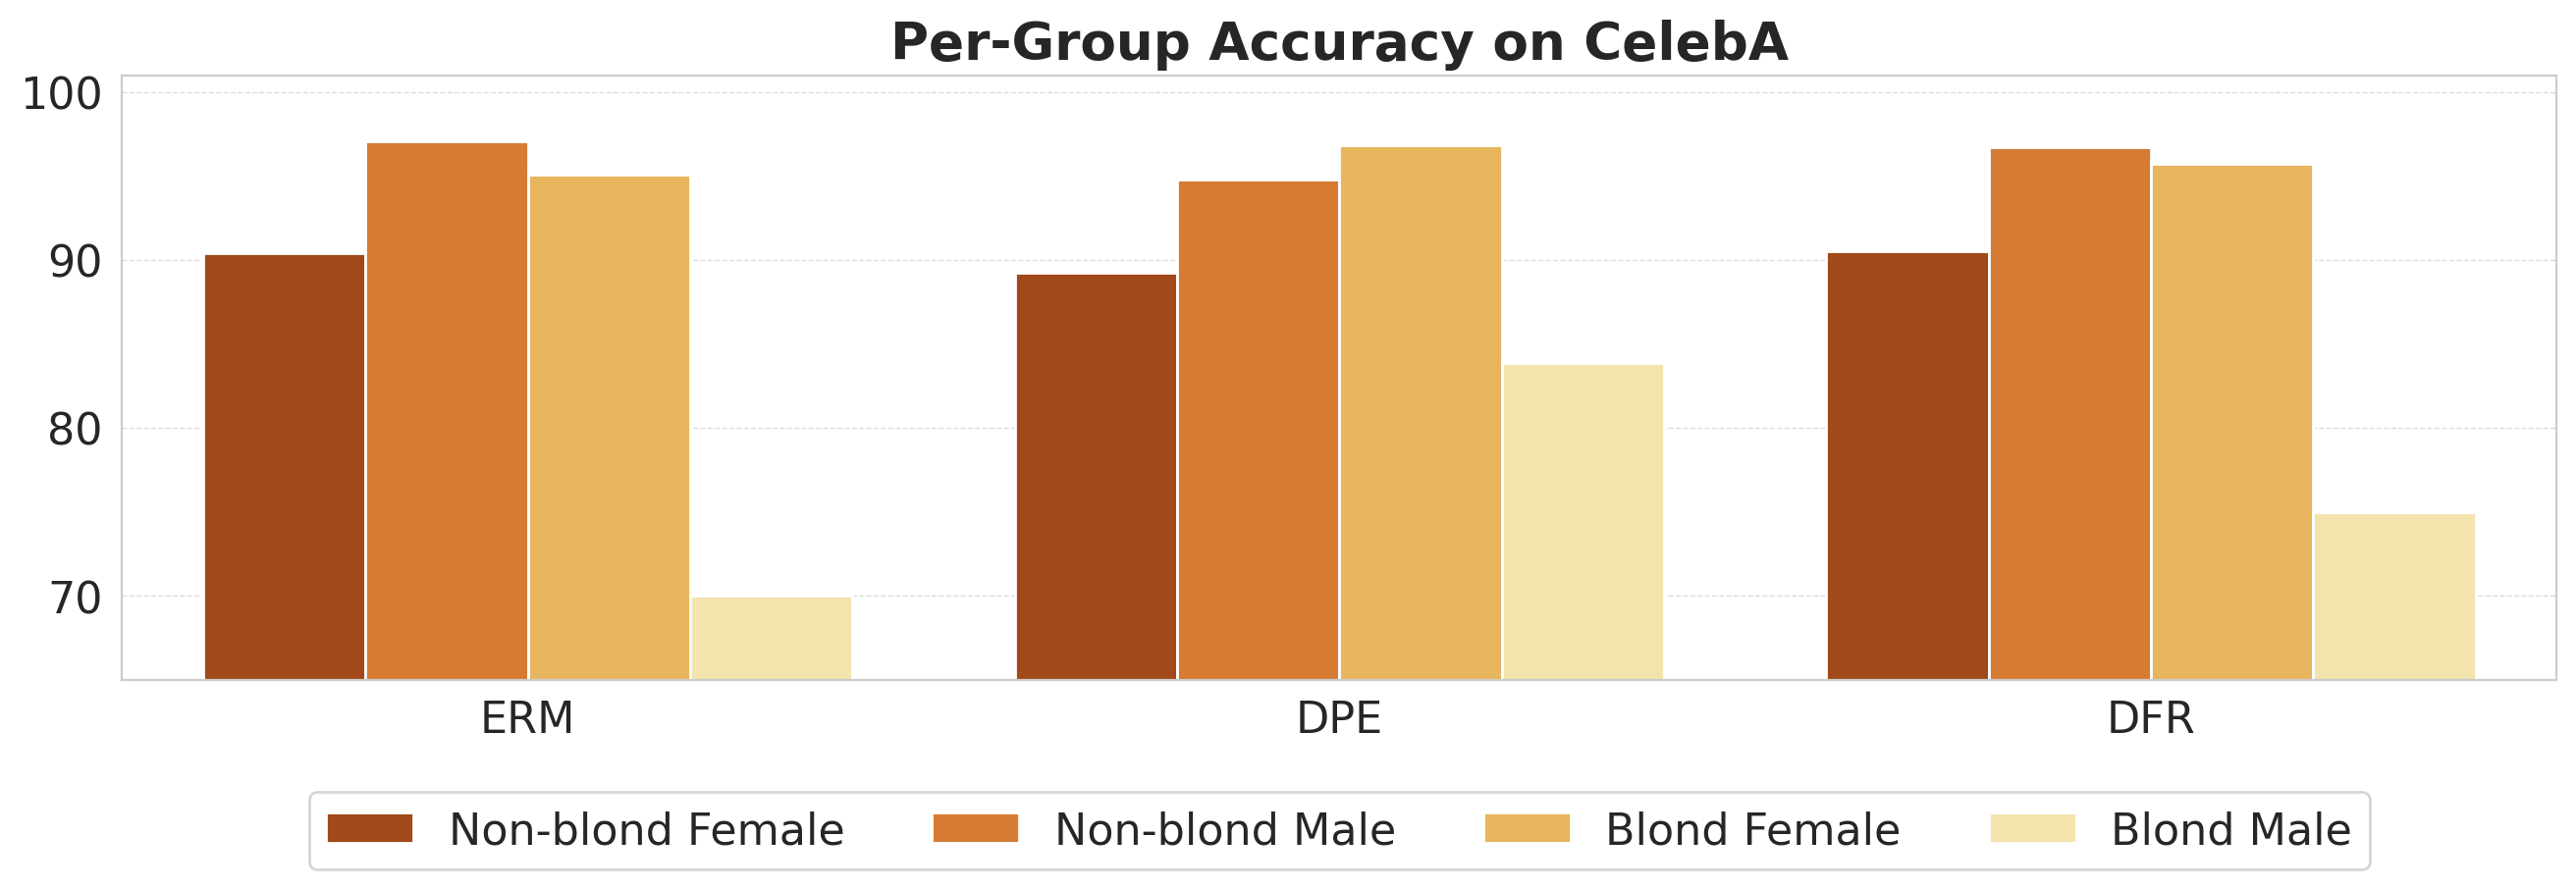

In [14]:
import pylab as plt
import pandas as pd

palette = ['#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', '#f781bf']

results = dict()
results['ERM'] = evaluate(erm_model, dataloaders['test'])
for k in metrics.keys():
    results[k] = metrics[k][-1]

df2 = []
for k in results.keys():
    per_group_acc = results[k]['per_group']
    tmp = {g: per_group_acc[g]['accuracy'] * 100 for g in per_group_acc.keys()}
    df2.append(pd.DataFrame(tmp.values(), columns=['Accuracy']))
    df2[-1]['Group'] = [groups_dict[kk] for kk in tmp.keys()]
    df2[-1]['Method'] = k
df2 = pd.concat(df2)
df2.reset_index(drop=True, inplace=True)
import seaborn as sns

plt.figure(figsize=(16, 4), dpi=200)
ax = sns.barplot(
    data=df2, x='Method', y='Accuracy', hue='Group',
    palette=sns.color_palette('YlOrBr', len(df2['Group'].unique()))[::-1],
    # palette=sns.color_palette(palette, 4)
)
ax.set_ylim(65, 101)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7, axis='y')

# Move legend below the x-axis label
ax.legend(
    # title='Group',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(df2['Group'].unique()),
    frameon=True
)
_ = plt.title('Per-Group Accuracy on CelebA', weight='bold')

# Remark
---

Our results demonstrate that DPE offer a flexible and effective framework for improving model robustness under subpopulation shift. DPE adapts naturally to settings where such information is unavailable by leveraging class-balanced subsampling and inter-model diversification. Across all evaluated metrics, DPE achieves more equitable performance across subgroups with minimal trade-offs on majority performance, highlighting its practical value in real-world deployment scenarios where subgroup structure is unknown.

---